## Gender prediction alone using BERT-base with 3 Datasets
- predict gender using Dementia Bank
- predict gender using Fisher
- predict gender using CORAAL

### Load modules

In [15]:
import sys
import os
import random

import itertools
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MultiLabelBinarizer

import pandas as pd
import numpy as np
import torch

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("./"), "..")))
from src.BinaryClassificationNN import BinaryClassificationNN
from src.MultiClassificationNN import MultiClassificationNN
from src.MultiLabel import MultiLabel

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

### Model Configuration

In [17]:
rand_seed_np = 2023,
rand_seed_torch = 2023
num_labels = 2
    
pretrained = "bert-base-uncased"
device = "cuda:0"

max_length = 256
num_epochs = 6
hidden_dropout_prob = 0.2
num_warmup_steps = 50
batch_size = 10
    
    
lr = 1e-5
grad_norm = 1.0
balance_weights = False

In [18]:
model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

In [19]:
# losses_dict = {}
# losses_dict["losses"] = []
# losses_dict["auroc"] = []
# losses_dict["auprc"] = []
# losses_dict["cm"] = []    
# losses = []
# _auroc = []
# _auprc = []
# _cm = []
    
random.seed(rand_seed_np)
np.random.seed(rand_seed_np)
torch.manual_seed(rand_seed_torch)
torch.cuda.manual_seed(rand_seed_torch)

/tmp/ipykernel_30120/2120851338.py:11: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(rand_seed_np)


### Healthy Dementia Bank Cohort

In [20]:
# Load data
df = pd.read_csv('./processed_db.csv', index_col=0)
df_wls = df[df['source'] == 0]
df_pitts = df[df['source'] == 1]

In [14]:
df[df['gender'] == 1].text[30]

"well the cookie jar is on the top shelf. the boy is falling off a stool. the sink is running over. the mother is standing in water. um the s the counter is too low. the mother's out of scale. the child is telling her brother to be quiet. the dishes look like they're falling off the cupboard. the um the wall and the countertops are not in scale. it's like they're not drawn proportionally. the walls are off. I guess that's about all I see. what am I missing. the sink is too narrow. it doesn't fit the cupboard. "

In [17]:
df[df['gender'] == 0].text[90]

"kitchen. kids. mom. sink's running over. kids are in the cookie jar. gonna fall off the stool. and what's going on outside. I don't see much outside. mom's doing dishes. the daughter's telling the. I assume the little girl was telling her brother to be quiet. but get I I don't want to say anything but get me a cookie too. "

#### Training with raw data

In [21]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state= 2023)

In [8]:
X_train = df_train["text"]
y_train = df_train['gender'].to_frame()

X_test = df_test["text"]
y_test = df_test['gender'].to_frame()

In [9]:
model = BinaryClassificationNN(**model_config)

model.load_pretrained()

model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")


Training Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

In [10]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

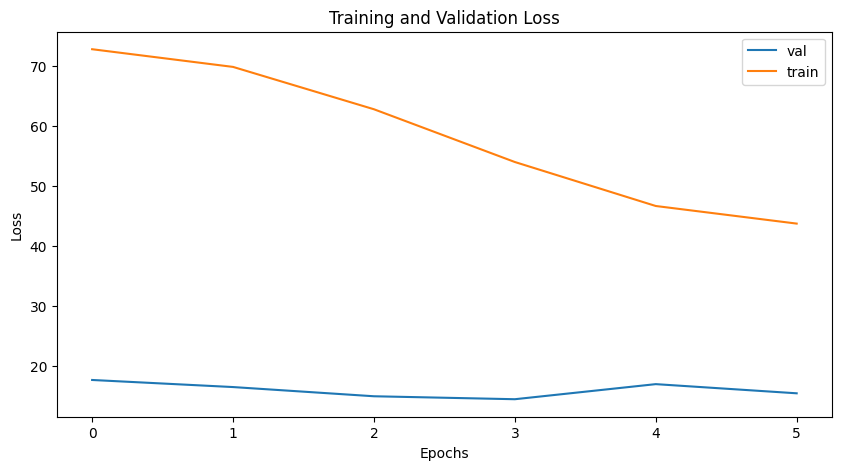

In [11]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
# Evaluation

y_pred, y_prob = model.predict(X=X_test, device="cuda:0")
    
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(torch.tensor(y_prob.values), torch.tensor(y_test.values).squeeze(1))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred)
auroc = metrics.roc_auc_score(y_true=y_test.values,y_score=y_prob.iloc[:,1])
auprc = metrics.average_precision_score(y_true=y_test.values,y_score=y_prob.iloc[:,1])
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred)
cm = metrics.confusion_matrix(y_true = y_test.values,y_pred = y_pred)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")

Loss: 0.5810509920120239, 
Accuracy: 0.7175572519083969, 
AUROC: 0.8111998064828254, 
AUPRC: 0.8615680408323216, 
F1: 0.7909604519774011


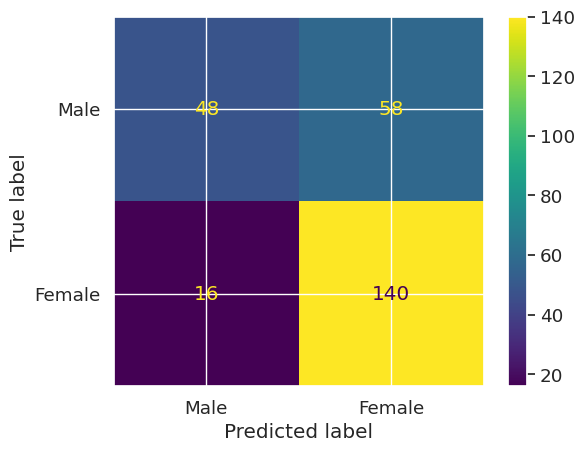

In [87]:
# Visualize confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
disp.plot()
plt.show()


In [71]:
y_pred.loc[:,0].value_counts()

1    198
0     64
Name: 0, dtype: int64

In [70]:
y_test.gender.value_counts()

1    156
0    106
Name: gender, dtype: int64

### Train with provenance
- Composite outcome

In [22]:
### Model Configuration
rand_seed_np = 2023,
rand_seed_torch = 2023
num_labels = 4
    
pretrained = "bert-base-uncased"
device = "cuda:0"

max_length = 256
num_epochs = 6
hidden_dropout_prob = 0.2
num_warmup_steps = 50
batch_size = 10
    
    
lr = 1e-5
grad_norm = 1.0
balance_weights = False

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

In [23]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [24]:
target_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [25]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state= 2023)

In [26]:
X_train = df_train["text"]
y_train = df_train['target'].to_frame()

X_test = df_test["text"]
y_test = df_test['target'].to_frame()

In [27]:
model = MultiClassificationNN(**model_config)
model.load_pretrained()

model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")


Training Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

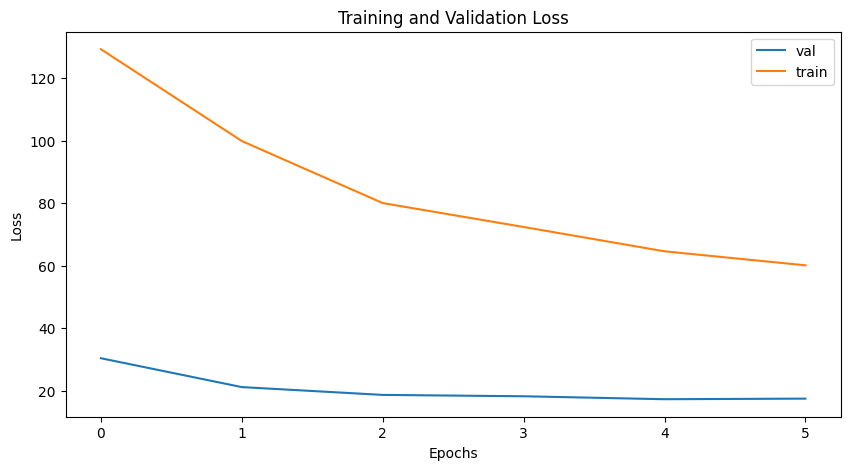

In [12]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
y_pred, y_prob = model.predict(X=X_test, device="cuda:0")

criterion = torch.nn.NLLLoss()

multilabel_binarizer = MultiLabelBinarizer(classes=range(num_labels))
mb_y = multilabel_binarizer.fit_transform(y_test.values)
mb_ypred = multilabel_binarizer.fit_transform(y_pred.values)

loss = criterion(torch.tensor(y_prob.values), torch.tensor(y_test.values).squeeze(1))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred)
auroc = metrics.roc_auc_score(y_true=mb_y,y_score=y_prob, average = 'micro')
auprc = metrics.average_precision_score(y_true=mb_y, y_score=y_prob, average = 'micro')
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred, average = 'micro')
cm = metrics.multilabel_confusion_matrix(y_true = y_test.values,y_pred = y_pred)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")



Loss: 0.6393942832946777, 
Accuracy: 0.6908396946564885, 
AUROC: 0.9130246877610084, 
AUPRC: 0.7445424152291612, 
F1: 0.6908396946564885


In [32]:
y_unique = y_test.target.unique()

In [34]:
y_pred, y_prob = model.predict(X=X_test, device="cuda:0")

In [35]:
mcm = metrics.confusion_matrix(y_test, y_pred, labels = y_unique)

In [36]:
mcm

array([[116,   1,   7,   0],
       [  3,  26,   0,   0],
       [ 64,   0,  28,   0],
       [  1,  15,   1,   0]])

In [37]:
target_mapping

{'pitts_female': 0, 'pitts_male': 1, 'wls_female': 2, 'wls_male': 3}

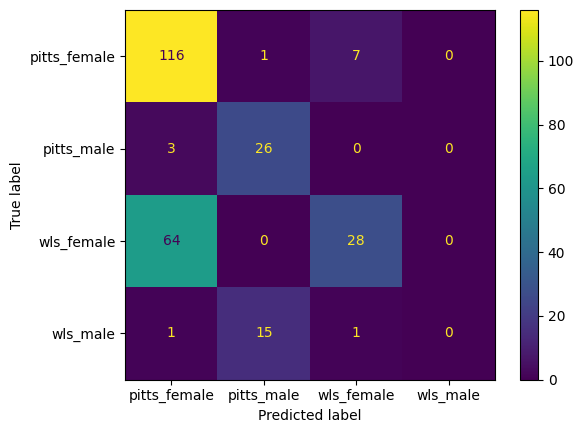

In [38]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=mcm, display_labels=['pitts_female', 'pitts_male',
                                                                            'wls_female', 'wls_male'])
disp.plot()
plt.show()

In [51]:
idx2label = {y: x for x, y in target_mapping.items()}

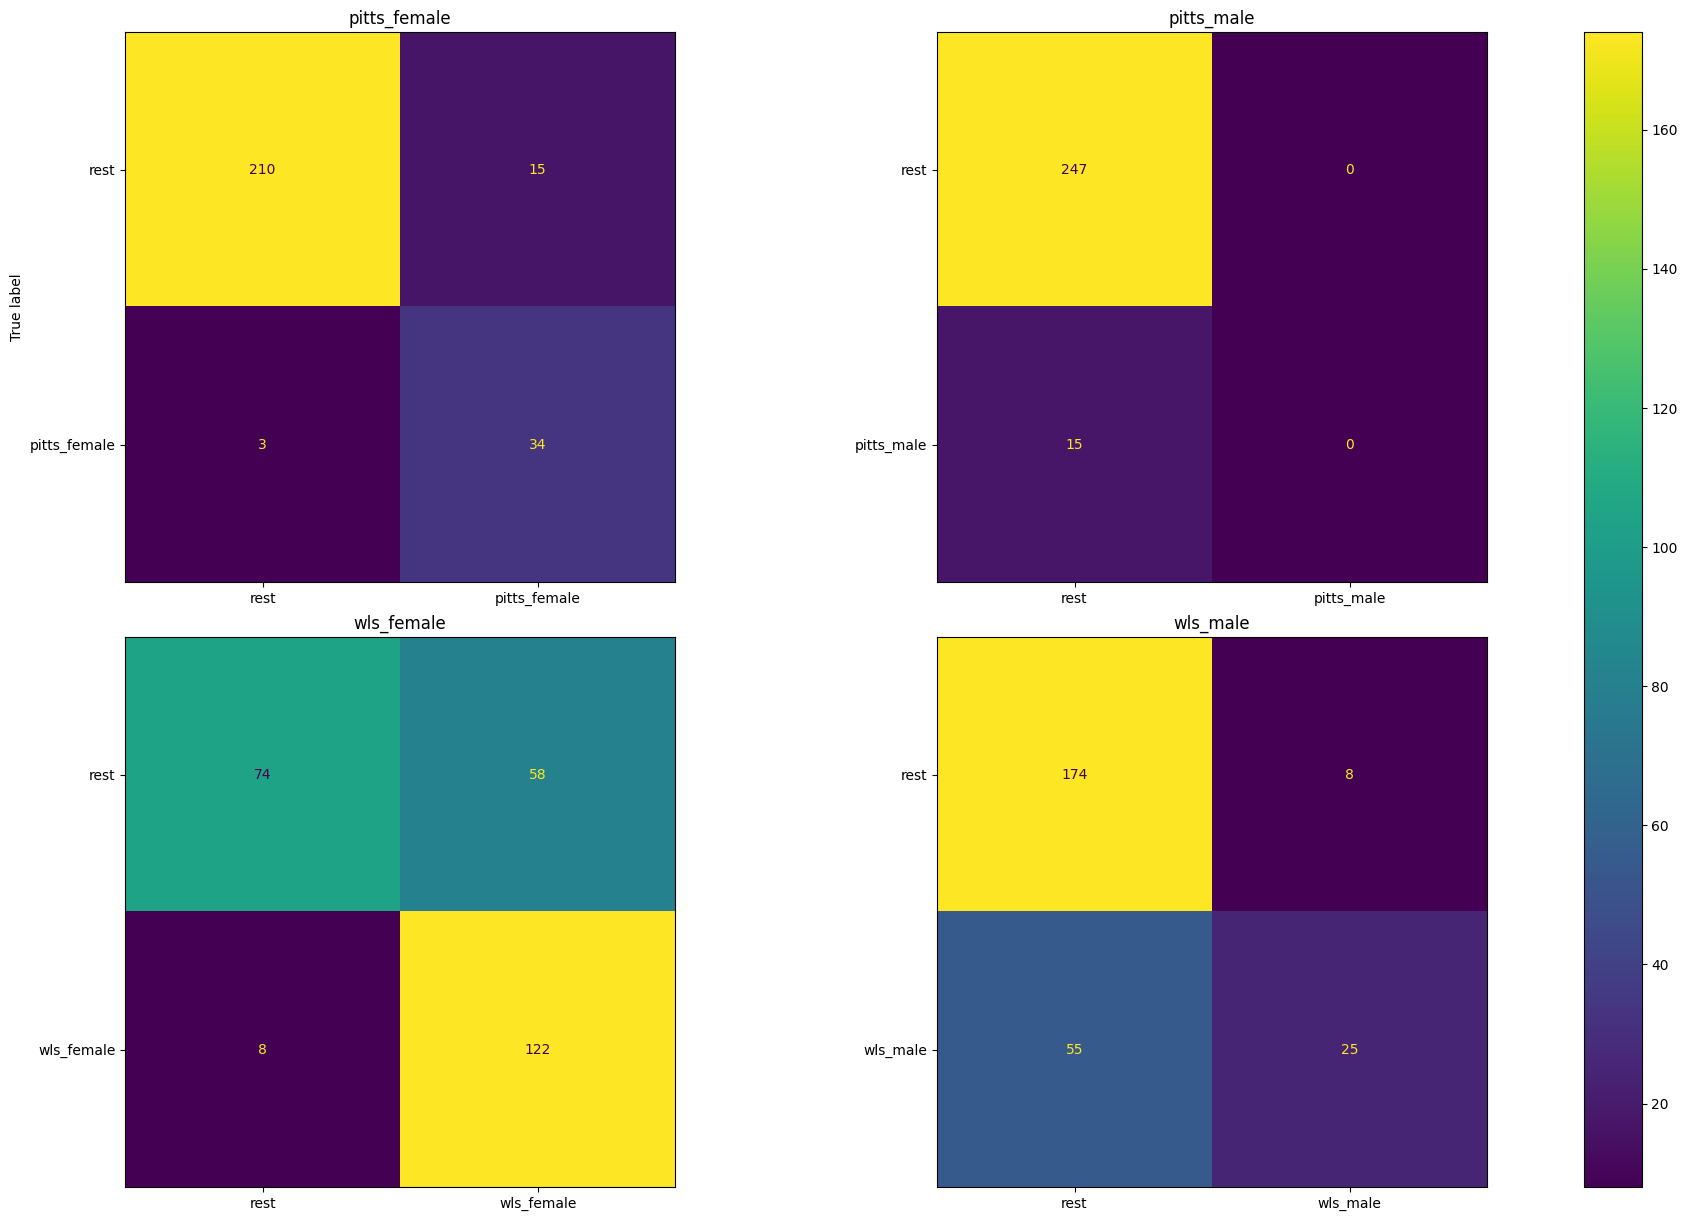

In [30]:

f, axes = plt.subplots(2,2, ffisher_label_mapping, 15)
axes = axes.ravel()
for i in range(num_labels):
    disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(mb_y[:, i],
                                                   mb_ypred[:, i]),
                                  display_labels=['rest', index2label[i]])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'{index2label[i]}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

- Multilabel outcome

In [32]:
le = LabelEncoder()
df['source'] = le.fit_transform(df['source'])
source_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [52]:
idx2label

{0: 'pitts_female', 1: 'pitts_male', 2: 'wls_female', 3: 'wls_male'}

In [41]:
df

,file,gender,age,text,source,target
0,2000000002,1,71.0,I see a woman washing dishes. the sink is over...,0,2
1,2000000007,1,66.0,okay. I see a girl. I see a boy a cookie jar c...,0,2
2,2000000032,1,71.0,well there's a cookie jar. there's the cover o...,0,2
3,2000000047,1,71.0,okay um a girl and a boy. he's standing on a s...,0,2
4,2000000054,1,70.0,well the boy is getting the getting a cookie j...,0,2
...,...,...,...,...,...,...
1309,686-0,1,78.0,well the little girl is reaching for a cookie....,1,0
1310,688-0,1,78.0,mhm. mhm alotof things are happening. yes the ...,1,0
1311,691-0,1,77.0,alright. the little boy girl's reaching up the...,1,0
1312,709-0,1,74.0,okay. well in the first place the the mother f...,1,0


In [34]:
### Model Configuration
rand_seed_np = 2023,
rand_seed_torch = 2023
num_labels = 2
    
pretrained = "bert-base-uncased"
device = "cuda:0"

max_length = 256
num_epochs = 6
hidden_dropout_prob = 0.2
num_warmup_steps = 50
batch_size = 10
    
    
lr = 1e-5
grad_norm = 1.0
balance_weights = False

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

In [35]:
X_train = df_train["text"]
y_train = df_train[['gender', 'source']]

X_test = df_test["text"]
y_test = df_test[['gender', 'source']]
    
model = MultiLabel(**model_config)
model.load_pretrained()
model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")

In [36]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

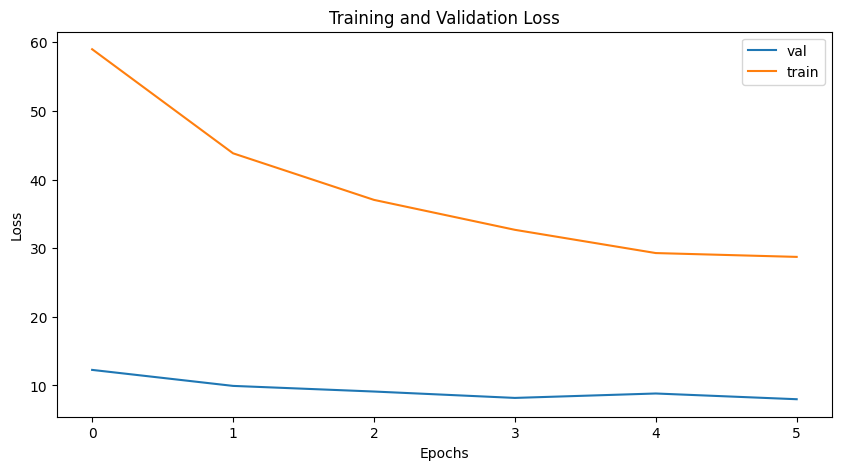

In [37]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [57]:
y_pred, y_prob = model.predict(X=X_test, device="cuda:0")

criterion = torch.nn.BCELoss()


loss = criterion(torch.FloatTensor(y_prob.to_numpy()), torch.FloatTensor(y_test.to_numpy()))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred.values)
auroc = metrics.roc_auc_score(y_true=y_test.values,y_score=y_prob.values, average = 'micro')
auprc = metrics.average_precision_score(y_true=y_test.values, y_score=y_prob.values, average = 'micro')
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred.values, average = 'micro')
cm = metrics.multilabel_confusion_matrix(y_true = y_test.values,y_pred = y_pred.values)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")



Loss: 0.29237598180770874, 
Accuracy: 0.7022900763358778, 
AUROC: 0.9481697731866157, 
AUPRC: 0.9315253963166635, 
F1: 0.821917808219178


In [58]:
cm

array([[[ 56,  39],
        [ 35, 132]],

       [[210,   0],
        [  4,  48]]])

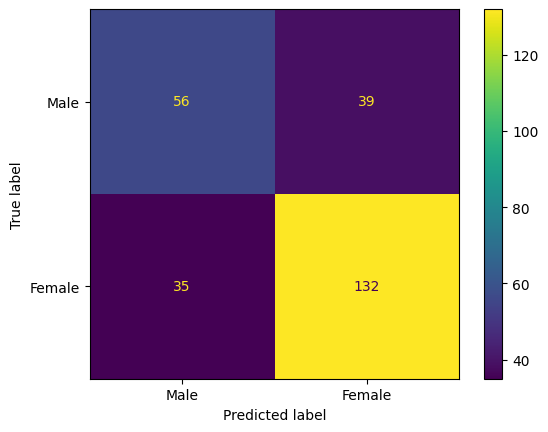

In [63]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=['Male', 'Female'])
disp.plot()
plt.show()


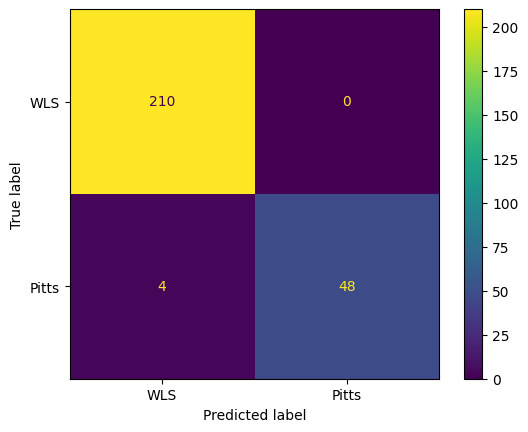

In [62]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm[1], display_labels=['WLS', 'Pitts'])
disp.plot()
plt.show()


### Fisher Cohort

In [18]:
# Load data
df_fisher = pd.read_csv('./processed_fisher.tsv', index_col=0, sep = '\t')

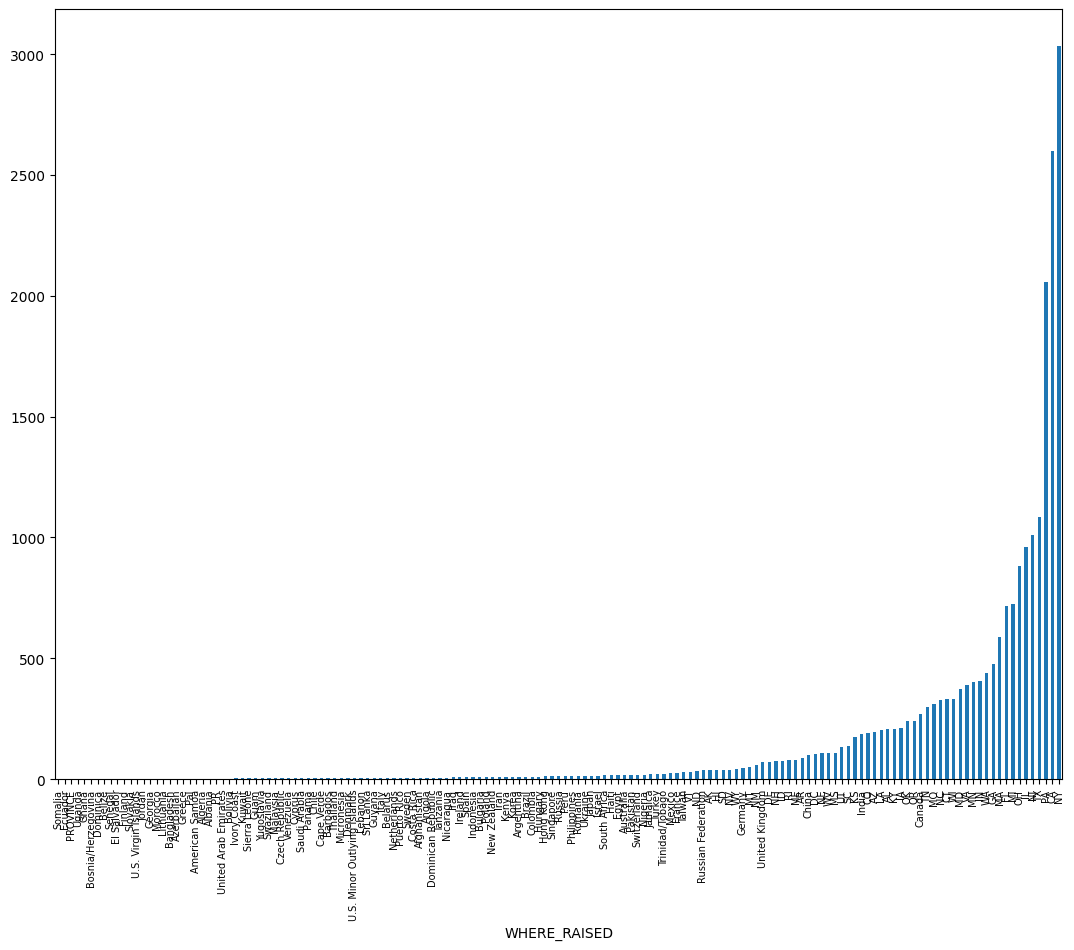

In [19]:
plt.figure(figsize = (13,10))
df_fisher.groupby("WHERE_RAISED").size().sort_values().plot.bar()
plt.xticks(fontsize=7, rotation=90)
plt.show()

In [20]:
df_fisher_us = df_fisher[df_fisher["WHERE_RAISED"].str.len()==2]

In [21]:
df_north = df_fisher_us.loc[df_fisher["WHERE_RAISED"] == 'MA']

In [22]:
df_south = df_fisher_us.loc[df_fisher["WHERE_RAISED"] == 'GA']

In [24]:
df_ns = pd.concat([df_north, df_south])
df_ns.WHERE_RAISED.value_counts()

MA    588
GA    477
Name: WHERE_RAISED, dtype: int64

In [25]:
df_ns['target'] = df_ns['S_SEX'] + '-' + df_ns["WHERE_RAISED"]
df_ns.head()

,conversation,speaker,text,DATE_TIME,TOPICID,SIG_GRADE,CNV_GRADE,PIN,SX.DL,PHNUM,PHSET,PHTYP,S_SEX,S_AGE,EDU,NATIVE_LANG,WHERE_RAISED,NSIDES,SIDE_DATA,target
60,1820,A,hello my name is maryanne i'm from massachus...,20030423_18:24:28,ENG29,4.0,3.0,12191,f.a,617361oni,NaN,2.0,F,39.0,16.0,English,MA,3,01642_A/f.a;01820_A/f.a;03873_B/f.a,F-MA
62,1883,A,hi my name's ed hi terry nice to talk with y...,20030424_15:15:08,ENG30,4.0,3.5,11051,m.a,972494gjn,NaN,2.0,M,65.0,17.0,English,MA,3,01883_A/m.a;01976_A/m.a;02262_B/m.a,M-MA
116,1879,A,hello hi i'm zoe yes hi how are you so wh...,20030424_15:04:10,ENG30,4.0,4.0,66851,f.a,no_APHNUM,NaN,NaN,F,25.0,16.0,English,MA,3,01761_B/f.a;01879_A/f.a;02107_B/f.a,F-MA
126,1889,A,hi well my name is jim crawford i live in in...,20030424_16:10:36,ENG30,3.5,3.5,61089,m.a,317247sfx,NaN,NaN,M,53.0,18.0,English,MA,3,01792_B/m.a;01889_A/m.a;01970_B/m.a,M-MA
132,1896,A,hi my name is marian (( [noise] )) mhm um...,20030424_16:22:56,ENG30,3.5,4.0,32368,f.a,978689bif,NaN,3.0,F,48.0,16.0,English,MA,3,01896_A/f.a;01990_B/f.a;02556_B/f.a,F-MA


In [26]:
le = LabelEncoder()
df_ns['target'] = le.fit_transform(df_ns['target'])
fisher_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [27]:
df_ns['gender'] = df_ns.S_SEX.map({'M':0, 'F':1})

In [28]:
df_ns['source'] = df_ns.WHERE_RAISED.map({'MA': 0, 'GA': 1})

In [35]:
df_ns[df_ns['gender'] == 0].text.iloc[10]

" joshua beer hello  (( hello ))  hi josh beer how are you  uh yeah actually this is my uh my second time  oh really yeah they called uh they called me last night it's actually been been the second uh second time in a row  um okay so last night's topic was pets and that's a nice uh [laughter] yeah so it's kind of funny that they go from pets and now we're supposed to talk about um life partners  (( exactly [laughter] ))  exactly yes it's kind a interesting so uh at at least they said at first life partners but now it's um what do we look for in in a life partner  yeah i think i think that would work um it's funny because i actually never um really had a a serious girlfriend at all until uh until about nine months ago  um and actually i'm i'm living with her now and and it's you know i just graduated from college about uh  it- it's going on a year now and it's just you know so funny because for the longest time it was like i wasn't looking at all you know and finally uh and finally that

#### Train with Raw data

In [96]:
df_train, df_test = train_test_split(df_ns, test_size=0.2)

X_train = df_train["text"]
y_train = df_train['gender'].to_frame()

X_test = df_test["text"]
y_test = df_test['gender'].to_frame()

In [111]:
model = BinaryClassificationNN(**model_config)

model.load_pretrained()

model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")

Training Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

In [112]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

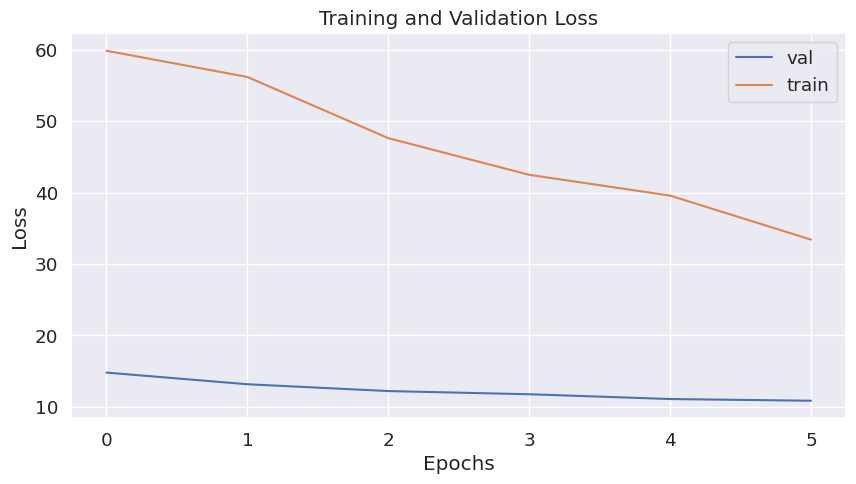

In [113]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [114]:
# Evaluation

y_pred, y_prob = model.predict(X=X_test, device="cuda:0")
    
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(torch.tensor(y_prob.values), torch.tensor(y_test.values).squeeze(1))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred)
auroc = metrics.roc_auc_score(y_true=y_test.values,y_score=y_prob.iloc[:,1])
auprc = metrics.average_precision_score(y_true=y_test.values,y_score=y_prob.iloc[:,1])
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred)
cm = metrics.confusion_matrix(y_true = y_test.values,y_pred = y_pred)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")

Loss: 0.5479055643081665, 
Accuracy: 0.7981220657276995, 
AUROC: 0.8423606210303457, 
AUPRC: 0.7706291092540871, 
F1: 0.7881773399014778


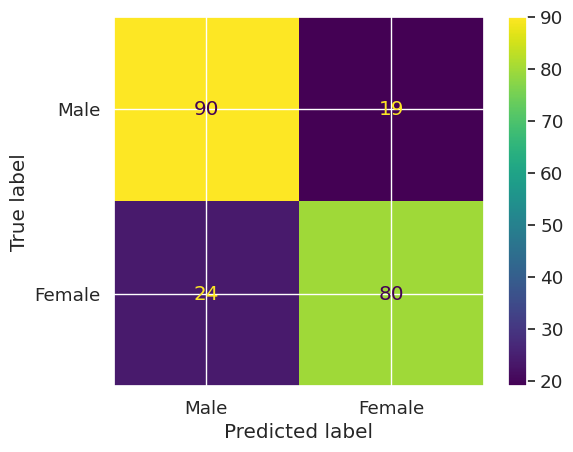

In [115]:
# Visualize confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
disp.plot()
plt.show()

### Train with provonance
- composite outcome 

In [92]:
### Model Configuration
rand_seed_np = 2023,
rand_seed_torch = 2023
num_labels = 4
    
pretrained = "bert-base-uncased"
device = "cuda:0"

max_length = 256
num_epochs = 15
hidden_dropout_prob = 0.2
num_warmup_steps = 50
batch_size = 10
    
    
lr = 1e-5
grad_norm = 1.0
balance_weights = False

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

In [104]:
df_train, df_test = train_test_split(df_ns, test_size=0.2, random_state=2023)

X_train = df_train["text"]
y_train = df_train['target'].to_frame()

X_test = df_test["text"]
y_test = df_test['target'].to_frame()

In [94]:
model = MultiClassificationNN(**model_config)
model.load_pretrained()

model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")

Training Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

In [98]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

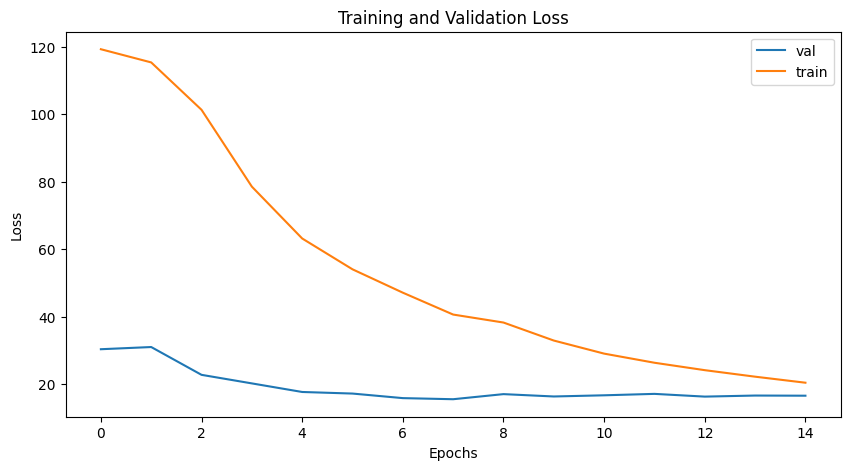

In [99]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [105]:
y_pred, y_prob = model.predict(X=X_test, device="cuda:0")

criterion = torch.nn.NLLLoss()

multilabel_binarizer = MultiLabelBinarizer(classes=range(num_labels))
mb_y = multilabel_binarizer.fit_transform(y_test.values)
mb_ypred = multilabel_binarizer.fit_transform(y_pred.values)

loss = criterion(torch.tensor(y_prob.values), torch.tensor(y_test.values).squeeze(1))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred)
auroc = metrics.roc_auc_score(y_true=mb_y,y_score=y_prob, average = 'micro')
auprc = metrics.average_precision_score(y_true=mb_y, y_score=y_prob, average = 'micro')
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred, average = 'micro')
cm = metrics.multilabel_confusion_matrix(y_true = y_test.values,y_pred = y_pred)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")


Loss: 0.7702591419219971, 
Accuracy: 0.6948356807511737, 
AUROC: 0.9109818010829714, 
AUPRC: 0.7831798358322242, 
F1: 0.6948356807511737


In [111]:
cm 

array([[[129,  25],
        [ 17,  42]],

       [[143,  15],
        [ 18,  37]],

       [[154,  16],
        [ 17,  26]],

       [[148,   9],
        [ 13,  43]]])

In [106]:
idx2label

{0: 'F-GA', 1: 'F-MA', 2: 'M-GA', 3: 'M-MA'}

In [101]:
idx2label = {y: x for x, y in fisher_label_mapping.items()}

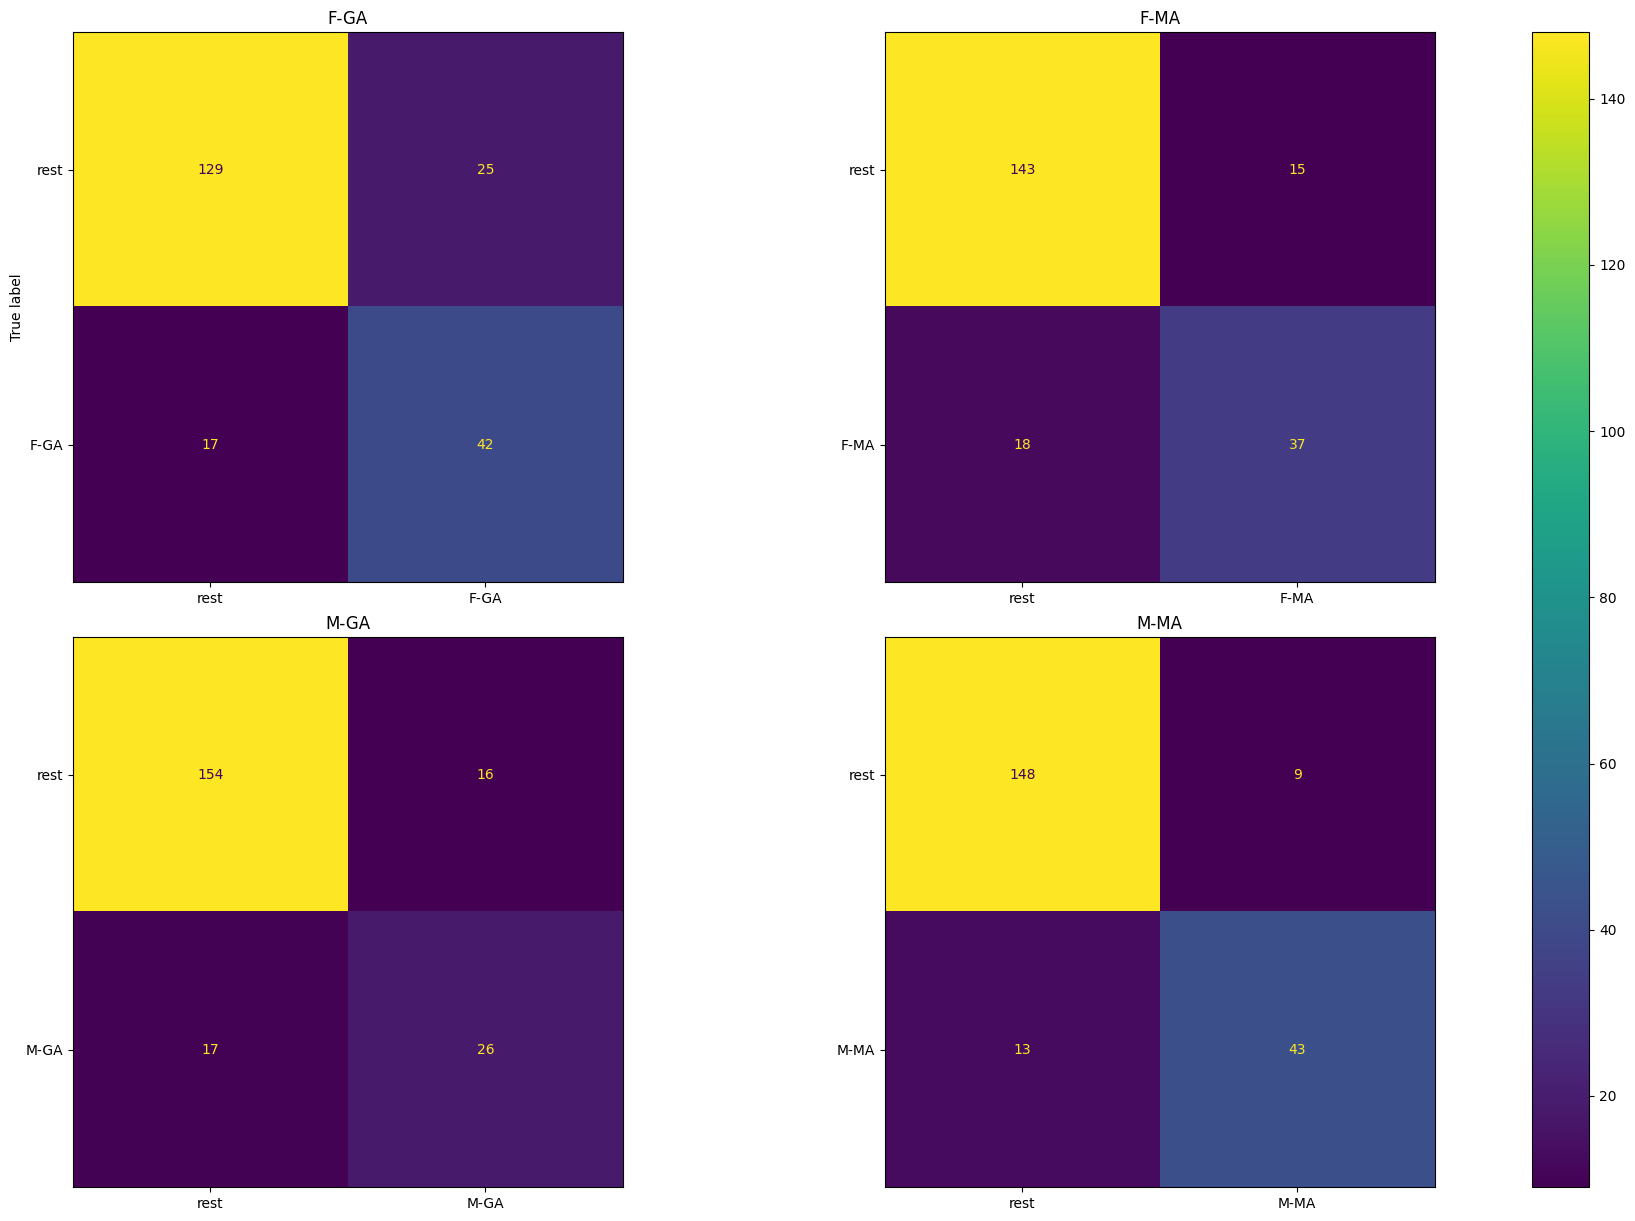

In [112]:
f, axes = plt.subplots(2,2, figsize=(25, 15))
axes = axes.ravel()
for i in range(num_labels):
    disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(mb_y[:, i],
                                                   mb_ypred[:, i]),
                                  display_labels=['rest', idx2label[i]])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'{idx2label[i]}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()

- multilabel outcome

In [118]:
### Model Configuration
rand_seed_np = 2023,
rand_seed_torch = 2023
#destination = '/home/sheng136/workspace/deDTN/code/DeconDTN/runs_zhecheng/output'
num_labels = 2
    
pretrained = "bert-base-uncased"
device = "cuda:0"

max_length = 256
num_epochs = 15
hidden_dropout_prob = 0.2
num_warmup_steps = 50
batch_size = 10
    
    
lr = 1e-5
grad_norm = 1.0
balance_weights = False

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

In [119]:
X_train = df_train["text"]
y_train = df_train[['gender', 'source']]

X_test = df_test["text"]
y_test = df_test[['gender', 'source']]
    
model = MultiLabel(**model_config)
model.load_pretrained()
model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")

In [120]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

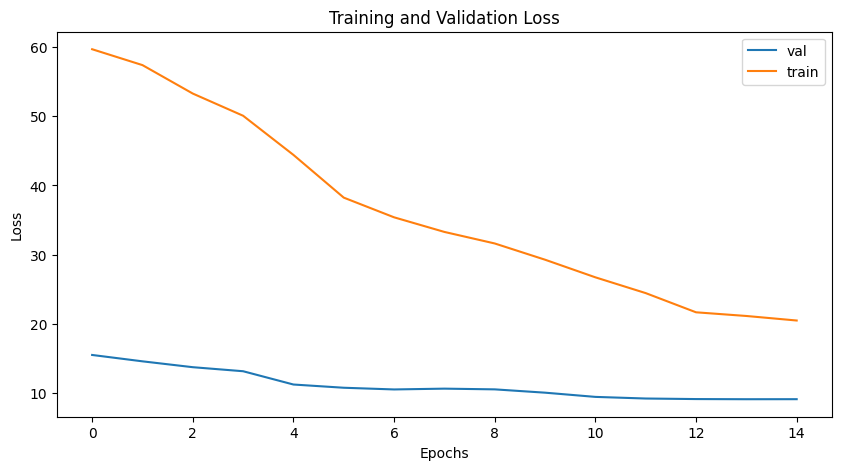

In [121]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [122]:
y_pred, y_prob = model.predict(X=X_test, device="cuda:0")

criterion = torch.nn.BCELoss()


loss = criterion(torch.FloatTensor(y_prob.to_numpy()), torch.FloatTensor(y_test.to_numpy()))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred.values)
auroc = metrics.roc_auc_score(y_true=y_test.values,y_score=y_prob.values, average = 'micro')
auprc = metrics.average_precision_score(y_true=y_test.values, y_score=y_prob.values, average = 'micro')
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred.values, average = 'micro')
cm = metrics.multilabel_confusion_matrix(y_true = y_test.values,y_pred = y_pred.values)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")


Loss: 0.4182511568069458, 
Accuracy: 0.6572769953051644, 
AUROC: 0.8961860670194004, 
AUPRC: 0.9047695403013344, 
F1: 0.8066825775656324


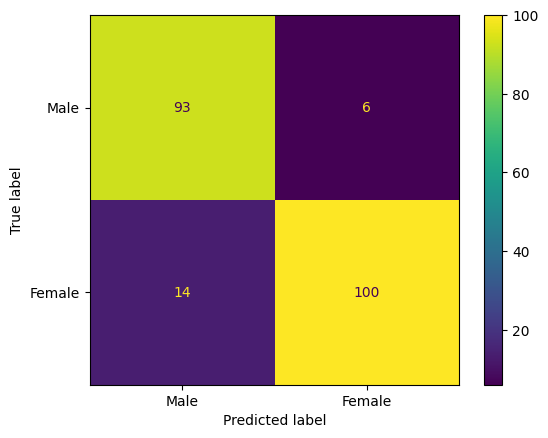

In [123]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm[0], display_labels=['Male', 'Female'])
disp.plot()
plt.show()

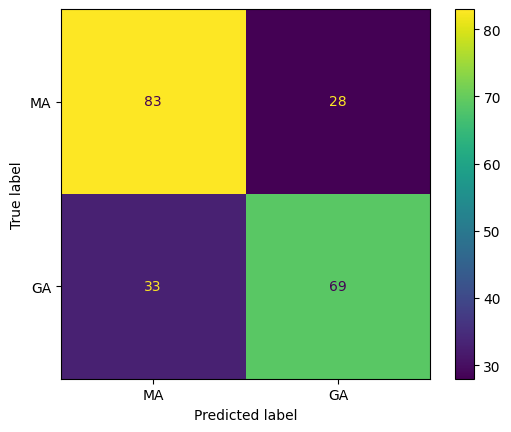

In [125]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm[1], display_labels=['MA', 'GA'])
disp.plot()
plt.show()

### CORAAL Cohort

In [127]:
# load data

df_cor = pd.read_csv('./processed_coraal.tsv', index_col=0)

In [128]:
df_cor.head()

,text,location,gender
DCA_se1_ag1_f_01_1,My-My name is /RD-NAME-6/.One two three four f...,DCA,f
DCA_se1_ag2_f_01_1,"Baseball (laughing), marbles, you know. Uh, Ma...",DCA,f
DCA_se1_ag1_f_03_1,"Um, baseball, football, basketball, tennis, ki...",DCA,f
DCA_se2_ag1_f_07_1,"Mm, /let me see/. Do you want me to answer tha...",DCA,f
DCA_se3_ag1_f_03_1,I play hopscotch and kickball and sometimes we...,DCA,f


In [129]:
df_cor.shape

(231, 3)

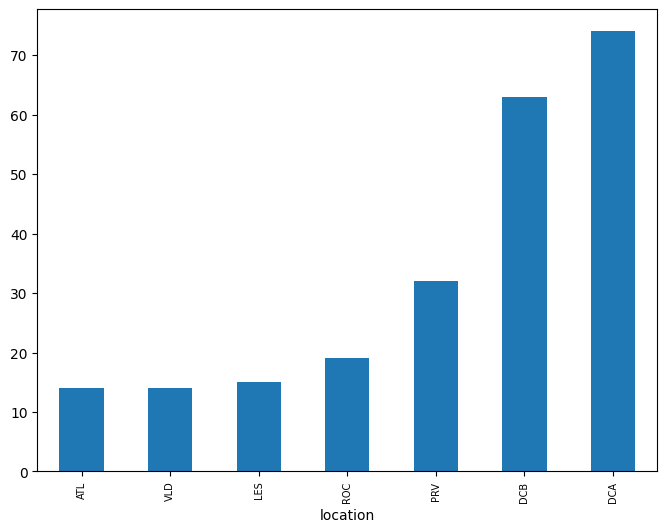

In [130]:
plt.figure(figsize = (8,6))
df_cor.groupby("location").size().sort_values().plot.bar()
plt.xticks(fontsize=7, rotation=90)
plt.show()

In [131]:
df_cor['gender'] = df_cor.gender.map({'m':0, 'f':1})

#### Train with Raw data

In [132]:
df_train, df_test = train_test_split(df_cor, test_size=0.2, random_state=2023)

X_train = df_train["text"]
y_train = df_train['gender'].to_frame()

X_test = df_test["text"]
y_test = df_test['gender'].to_frame()

In [141]:
### Model Configuration
rand_seed_np = 2023,
rand_seed_torch = 2023
num_labels = 2
    
pretrained = "bert-base-uncased"
device = "cuda:0"

max_length = 256
num_epochs = 5
hidden_dropout_prob = 0.2
num_warmup_steps = 50
batch_size = 10
    
    
lr = 1e-5
grad_norm = 1.0
balance_weights = False

model_config = {}
# model_config['model_type'] = model_type
model_config["pretrained"] = pretrained
model_config["max_length"] = max_length
model_config["num_labels"] = num_labels
model_config["hidden_dropout_prob"] = hidden_dropout_prob
model_config["num_epochs"] = num_epochs
model_config["num_warmup_steps"] = num_warmup_steps
model_config["batch_size"] = batch_size
model_config["lr"] = lr
model_config["balance_weights"] = balance_weights
model_config["grad_norm"] = grad_norm

In [142]:
model = BinaryClassificationNN(**model_config)

model.load_pretrained()

model.trainModelWithTest(X=X_train, y=y_train,X_test=X_test, y_test = y_test, device="cuda:0")

Training Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

In [143]:
train_losses = model.loss_epochs
val_losses = model.loss_test_epochs

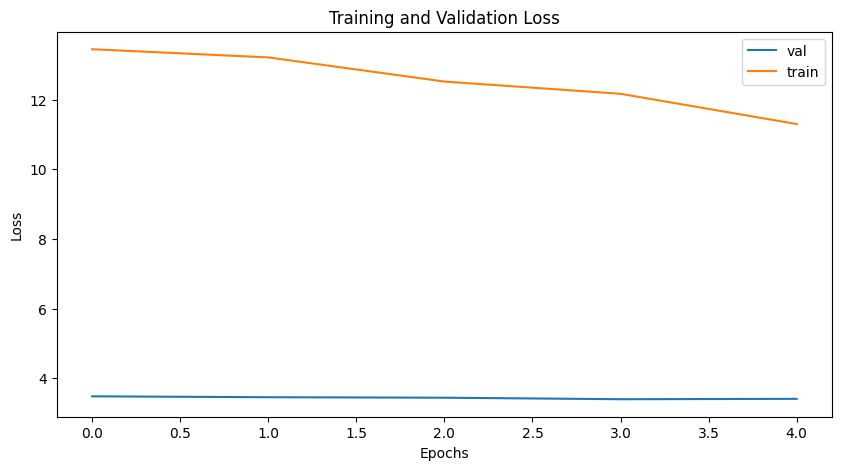

In [144]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [145]:
# Evaluation

y_pred, y_prob = model.predict(X=X_test, device="cuda:0")
    
criterion = torch.nn.CrossEntropyLoss()
loss = criterion(torch.tensor(y_prob.values), torch.tensor(y_test.values).squeeze(1))
acc = metrics.accuracy_score(y_true = y_test.values, y_pred=y_pred)
auroc = metrics.roc_auc_score(y_true=y_test.values,y_score=y_prob.iloc[:,1])
auprc = metrics.average_precision_score(y_true=y_test.values,y_score=y_prob.iloc[:,1])
f1 = metrics.f1_score(y_true = y_test.values, y_pred = y_pred)
cm = metrics.confusion_matrix(y_true = y_test.values,y_pred = y_pred)

print(f"Loss: {loss}, \nAccuracy: {acc}, \nAUROC: {auroc}, \nAUPRC: {auprc}, \nF1: {f1}")

Loss: 0.6795579195022583, 
Accuracy: 0.574468085106383, 
AUROC: 0.5727272727272728, 
AUPRC: 0.49110452627537265, 
F1: 0.6153846153846153


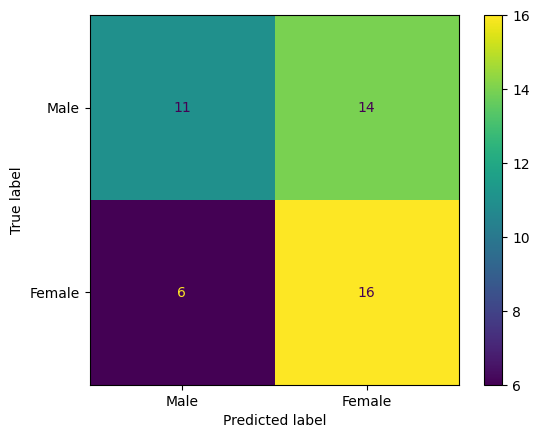

In [146]:
# Visualize confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
disp.plot()
plt.show()

In [140]:
y_pred.loc[:,0].value_counts()

1    31
0    16
Name: 0, dtype: int64

In [142]:
y_test.gender.value_counts()

0    27
1    20
Name: gender, dtype: int64

In [ ]:
# Won't use CORAAL For gender prediction